In [1]:
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm
import itertools
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import date
from os.path import join, isfile
from os import listdir
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

In [2]:
def read_rep(kdv_csv, ID_csv, low_age, high_age, data_dir):
    
    # open directories
    kdv_dir = data_dir+"\\kdv-patients-age-group-"+str(low_age) + "-" + str(high_age)
    ID_dir = data_dir+ "\\kdv-selected-ID-controls-age-group-"+str(low_age) + "-" + str(high_age)

    # get list of filenames
    files_kdv = [f for f in listdir(kdv_dir) if (isfile(join(kdv_dir, f)) & ("crop_sized.jpg" in f))]
    files_ID = [f for f in listdir(ID_dir) if (isfile(join(ID_dir, f)) & ("crop_sized.JPG" in f))]
    
    data = []
    labels = []

    for i, csv_file in enumerate([ID_csv, kdv_csv]):
        with open (csv_file, newline='') as file:
            reader = csv.reader(file, delimiter=',')
            for row in reader:
                if row[0] in files_kdv or row[0] in files_ID:
                    rep = list(map(float, row[1:]))
                    data.append(row)
                    labels.append(i)
    
    return np.array(data), np.array(labels)

In [3]:
def plot_pca_tsne(data, labels, lowest_age = -1, highest_age = -1):
    plt.figure(figsize=(12,6))
    plt.plot([1,2])

    # visualize data in tnse (men/women)
    X_embedded_tsne = TSNE(n_components=2, init='pca').fit_transform(data)

    plt.subplot(121)
    unique = list(set(labels))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    for i, u in enumerate(unique):
        xi = [X_embedded_tsne[j, 0] for j  in range(len(X_embedded_tsne[:,0])) if labels[j] == u]
        yi = [X_embedded_tsne[j, 1] for j  in range(len(X_embedded_tsne[:,1])) if labels[j] == u]
        plt.scatter(xi, yi, c=[colors[i]], label=str(u))
    plt.legend()
    plt.title("t-sne for age range {}-{}".format(lowest_age, highest_age))

    # visualize data in pca (men/women)
    X_embedded_pca = PCA(n_components=2).fit_transform(data)

    plt.subplot(122)
    unique = list(set(labels))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    for i, u in enumerate(unique):
        xi = [X_embedded_pca[j, 0] for j  in range(len(X_embedded_pca[:,0])) if labels[j] == u]
        yi = [X_embedded_pca[j, 1] for j  in range(len(X_embedded_pca[:,1])) if labels[j] == u]
        plt.scatter(xi, yi, c=[colors[i]], label=str(u))
    plt.legend()
    plt.title("pca for age range{}-{}".format(lowest_age, highest_age))

    plt.show()

In [4]:
def plot_roc_curve(y_true, y_pred): 
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.figure(1, figsize=(12,6))
    roc_auc = roc_auc_score(y_true, y_pred)
    plt.plot(fpr, tpr, lw=2, alpha=0.5, label='LOOCV ROC (AUC = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [5]:
def normalize(data, i):

    if i == 0:
        return data
    
    if i == 1:
        return Normalizer().fit_transform(data)
        
    if i == 2:
        return StandardScaler().fit_transform(data)
        

### SVM

In [6]:
def svm_classifier_conf_matrix(data, labels, k, norm):

            
    data = normalize(data, norm) 
    all_y, all_probs, all_preds = [], [], [] 
    
    loo = LeaveOneOut()

    # leave one out split and make prediction
    for train, test in loo.split(data):
        all_y.append(labels[test])
        model = SVC(kernel=k, probability=True)
        model = model.fit(data[train], labels[train])
        all_probs.append(model.predict_proba(data[test].reshape(1, -1))[:,1])
        all_preds.append(model.predict(data[test].reshape(1, -1)))

    # based on all predictions make aroc curve and confusion matrix
    aroc = roc_auc_score(all_y, all_probs)
    tn, fp, fn, tp = confusion_matrix(all_y, all_preds).ravel()
    spec = tn / (tn+fp)  
    sens = tp / (tp+fn)

                
    return tn, fp, fn, tp, aroc

In [7]:
def concatenate(data_df, labels_df, data_dlib, labels_dlib, data_combination, nr_feats):
    # assert data has same shape and labels are exactly the same
    assert data_df.shape[0] == data_dlib.shape[0]
    assert labels_df.shape == labels_dlib.shape
    match = [i == j for i, j in zip(labels_df, labels_dlib)]
    assert False not in match
                
                
    if data_combination == 7:
        # openface + cfps 
        openface_data = data_df[:,1:] # openface
        cfps_data = data_dlib[:,1:] # cfps
        labels_openface = labels_dlib
        
        openface_names = data_df[:,0]
        cfps_names = data_dlib[:,0]

        
        matches = [i==j for i, j in zip(openface_names, cfps_names)]

        data, labels  = [], []
        if False not in matches:
            for index, (openface_i, cfps_i) in enumerate(zip(openface_data, cfps_data)):
                rep_list = openface_i.tolist()+cfps_i.tolist()
                rep = [float(i) for i in rep_list]
                data.append(rep) # concatenation of 128 openface + 340 cfps
                labels.append(labels_openface[index].astype(np.float64))
        else:
            print("Not the same image names for openface and cfps representation.")

   
    return 0, np.array(data), np.array(labels)
    

Aroc: 0.8280936454849499
Specificity: 0.782608695652174
Sensitivity: 0.6923076923076923


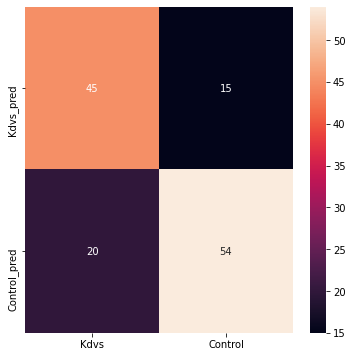

In [12]:
def main():    

    data_dir = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\kdv" 
    
    low_age = 1
    high_age = 40

    method = "openface"
    kdv_csv = data_dir+"\\representations\kdv-patients-"+method+".csv"  
    ID_csv  = data_dir+"\\representations\ID-controls-"+method+".csv"
    data_openface, labels_openface = read_rep(kdv_csv, ID_csv, low_age, high_age, data_dir)

    method = "cfps"
    kdv_csv = data_dir+"\\representations\kdv-patients-"+method+".csv"  
    ID_csv  = data_dir+"\\representations\ID-controls-"+method+".csv"
    data_cfps, labels_cfps = read_rep(kdv_csv, ID_csv, low_age, high_age, data_dir)


    nr_comps, data, labels = concatenate(data_openface, labels_openface, data_cfps, labels_cfps, 7, 0)
   
    kernel = 'sigmoid'
    normalize = 1
    
    tn, fp, fn, tp, aroc = svm_classifier_conf_matrix(data, labels, kernel, normalize)
    spec = tn / (tn+fp)  
    sens = tp / (tp+fn)

    print("Aroc: {}".format(aroc))
    print("Specificity: {}".format(spec))
    print("Sensitivity: {}".format(sens))
    
    
    conf_matrix = [[tp, fp],
             [fn, tn]]
    df_cm = pd.DataFrame(conf_matrix, index = ["Kdvs_pred", "Control_pred"],
                      columns = ["Kdvs", "Control"])
    plt.figure(figsize = (6, 6))
    sns_heat = sns.heatmap(df_cm, annot=True)
    plt.show()


    
main()
    